## Курсовой проект "Прогноз цен на недвижимость".

#### Подключение библиотек и скриптов

In [962]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

#### Пути к директориям и файлам

In [963]:
TRAIN_DATASET_PATH = 'project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'project_task/test.csv'

## Загрузка данных

Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [964]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [965]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


## 1. Подготовка данных

### - анализ

In [966]:
# Количественные переменные

In [967]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [968]:
# Номинативные переменные

In [969]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [970]:
#Cравним датасеты

In [971]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [972]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [973]:
#Приведение типов

In [974]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [975]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [976]:
train_df['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

### - визуализация

#### Распределение целевой переменной (Price)

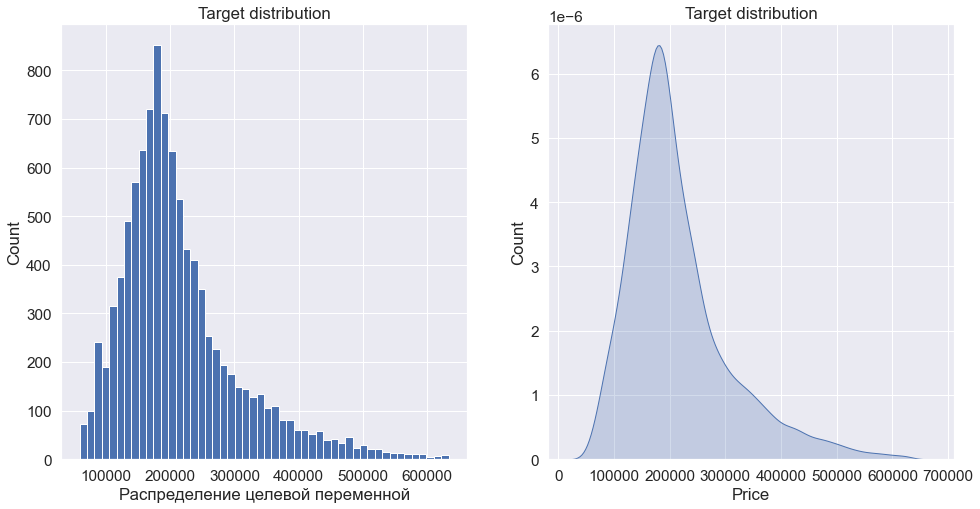

In [977]:
# логнормальное распределение
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(bins = 50)
plt.ylabel('Count')
plt.xlabel('Распределение целевой переменной')
plt.title('Target distribution')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')

plt.show()

In [978]:
# Посмотрим на распределение других признаков

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

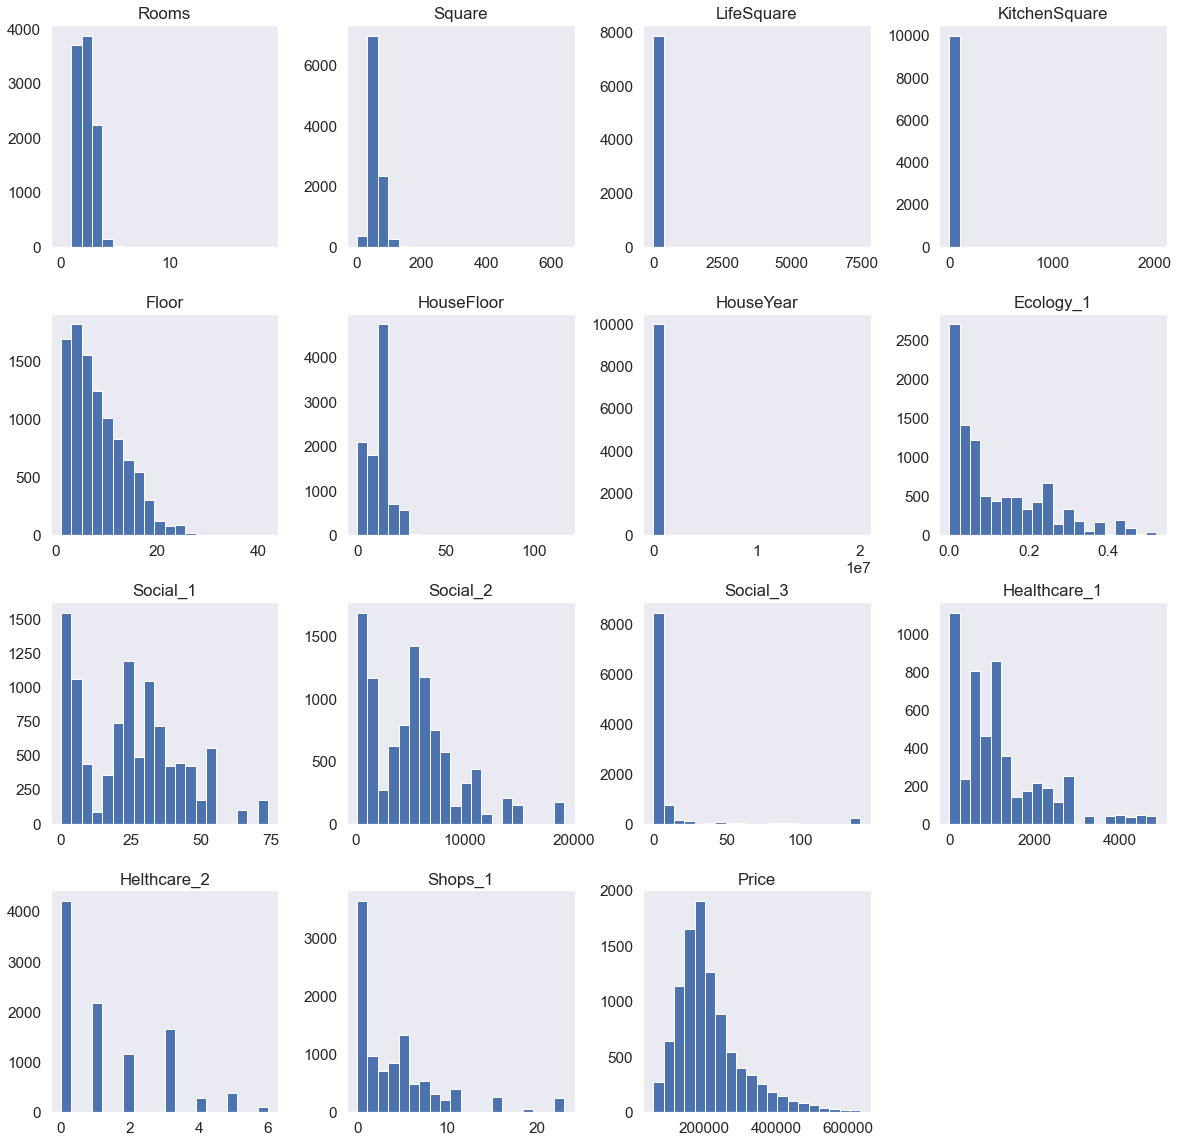

In [979]:
train_df.hist(figsize=(20, 20), bins=20, grid=False)

In [980]:
# Выявим зависимости признаков (матрица корреляции)

<AxesSubplot:>

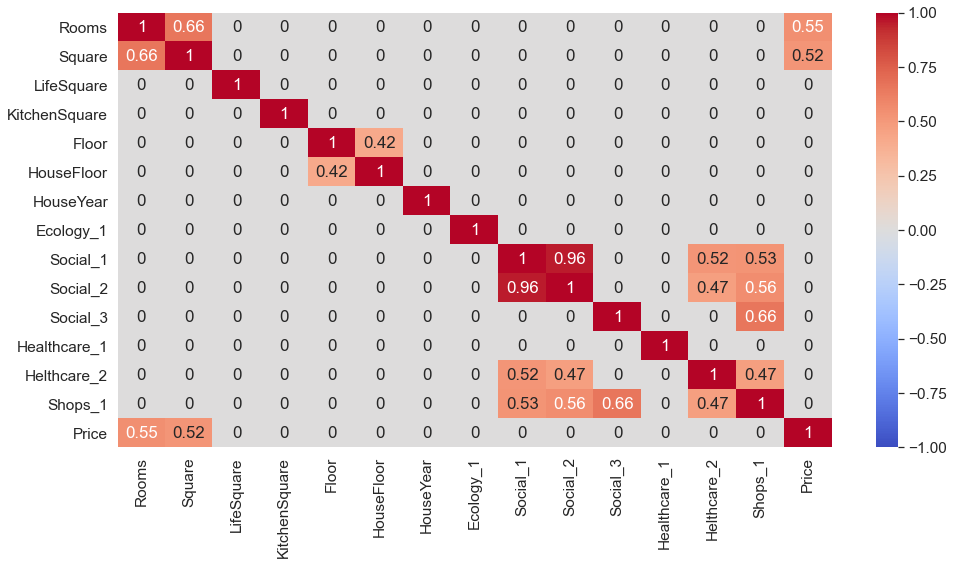

In [981]:
plt.figure(figsize = (16, 8))
sns.set(font_scale=1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [982]:
# Согласно нашей матрице, эти переменные больше всего коррелируют с «Price»:
# 'Rooms' и 'Square'
# 'Social_1' и 'Social_2' сильно коррелируют между собой
# 'Shops_1' и Social_1 - Social_3 и Helthcare_2 

In [983]:
# Анализ зависимости таргета от фичей

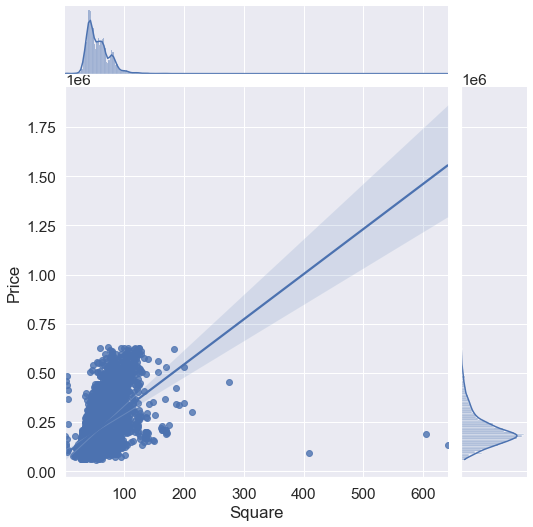

In [984]:
grid = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### - обработка выбросов

In [985]:
#Square, LifeSquare, KitchenSquare

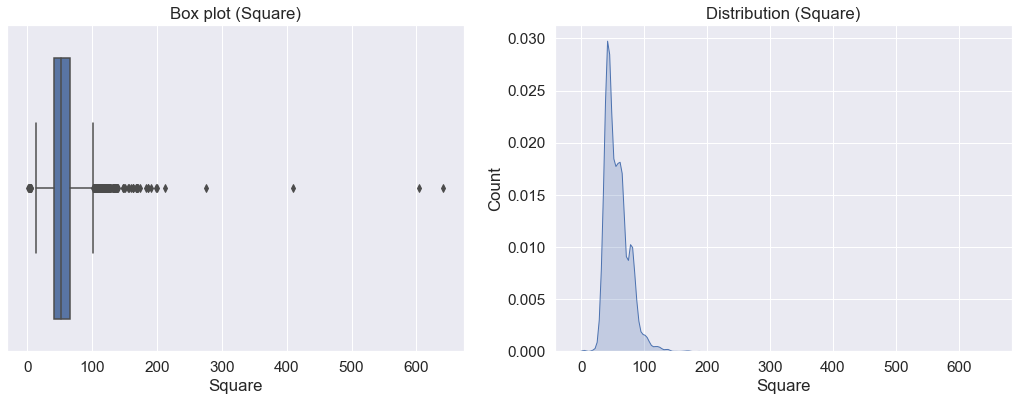

In [986]:
plt.figure(figsize = (18, 6))
plt.subplot(121)
plt.title('Box plot (Square)')
sns.boxplot(train_df['Square'], whis=1.5)
plt.xlabel('Square')

plt.subplot(122)
sns.kdeplot(train_df['Square'], shade=True, legend=False)
plt.ylabel('Count')
plt.xlabel('Square')
plt.title('Distribution (Square)')
plt.show()

In [987]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

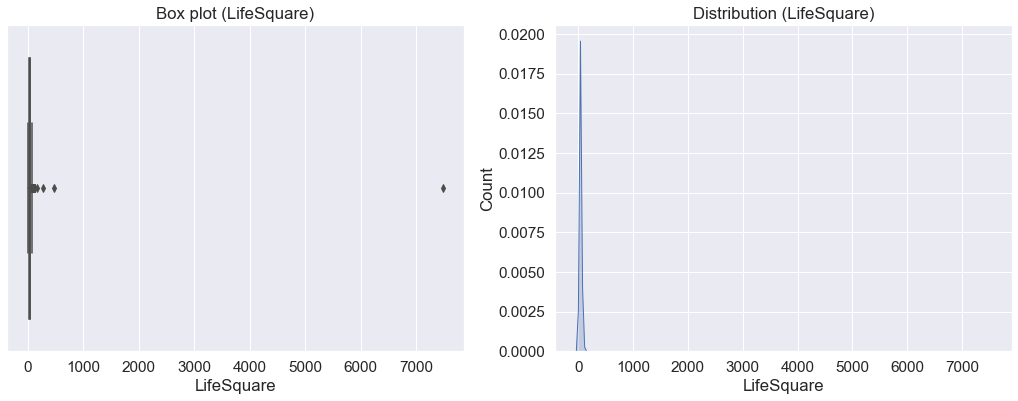

In [988]:
plt.figure(figsize = (18, 6))
plt.subplot(121)
plt.title('Box plot (LifeSquare)')
sns.boxplot(train_df['LifeSquare'], whis=1.5)
plt.xlabel('LifeSquare')

plt.subplot(122)
sns.kdeplot(train_df['LifeSquare'], shade=True, legend=False)
plt.ylabel('Count')
plt.xlabel('LifeSquare')
plt.title('Distribution (LifeSquare)')
plt.show()

In [989]:
train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

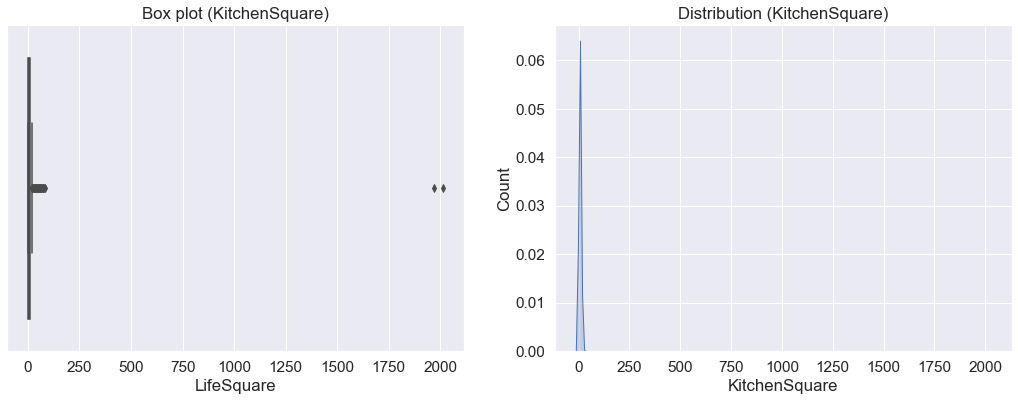

In [990]:
plt.figure(figsize = (18, 6))
plt.subplot(121)
plt.title('Box plot (KitchenSquare)')
sns.boxplot(train_df['KitchenSquare'], whis=1.5)
plt.xlabel('LifeSquare')

plt.subplot(122)
sns.kdeplot(train_df['KitchenSquare'], shade=True, legend=False)
plt.ylabel('Count')
plt.xlabel('KitchenSquare')
plt.title('Distribution (KitchenSquare)')
plt.show()

In [991]:
train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [992]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [993]:
#Rooms

In [994]:
train_df.loc[train_df['Rooms'] <= 0, 'Rooms'] = int(train_df['Rooms'].mode()[0])
train_df.loc[train_df['Rooms'] > 5, 'Rooms'] = int(train_df['Rooms'].mode()[0])

In [995]:
#HouseYear

In [996]:
train_df.loc[train_df['HouseYear'] > 2022, 'HouseYear'] = int(train_df['HouseYear'].mode()[0])

In [997]:
#HouseFloor

In [998]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

Text(0.5, 0, 'HouseFloor')

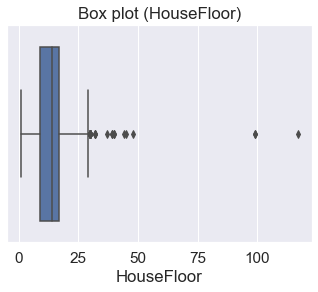

In [999]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title('Box plot (HouseFloor)')
sns.boxplot(train_df['HouseFloor'], whis=1.5)
plt.xlabel('HouseFloor')

In [1000]:
train_df.loc[train_df['HouseFloor'] > 50, 'HouseFloor'] = int(train_df['HouseFloor'].mode()[0])

In [1001]:
#Floor

Text(0.5, 0, 'Floor')

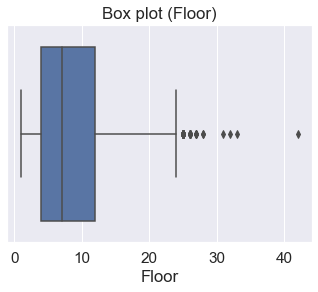

In [1002]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title('Box plot (Floor)')
sns.boxplot(train_df['Floor'], whis=1.5)
plt.xlabel('Floor')

In [1003]:
train_df.loc[train_df['Floor'] > 40, 'Floor'] = int(train_df['Floor'].mode()[0])

In [1004]:
#Social_3

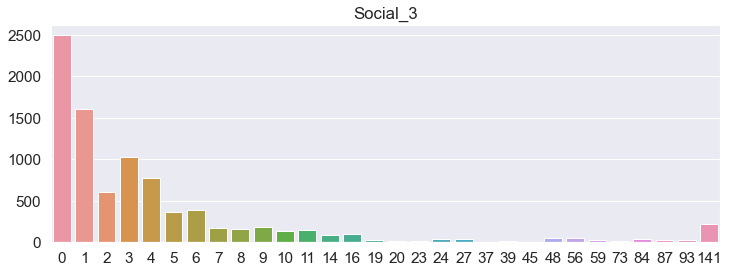

In [1005]:
counts = train_df['Social_3'].value_counts()
    
plt.figure(figsize=(12, 4))    
plt.title('Social_3')
sns.barplot(counts.index, counts.values)
    
plt.show()

In [1006]:
train_df.loc[train_df['Social_3'] > 93, 'Social_3'] = int(train_df['Social_3'].median())

### - обработка пропусков

In [1007]:
#LifeSquare

In [1008]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [1009]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

In [1010]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [1011]:
#Healthcare_1

In [1012]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### - генерация фичей

In [1013]:
class FeatureGenetator():
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None        
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        self.square_health_medians = None
        
    def fit(self, X):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})                       
        
        # District, Rooms, MedPriceByDistrict
        df = X.copy()        
        self.square_health_medians = df[['LifeSquare', 'Healthcare_1']].median()        
        df['Price'] = y.values            
        self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})            
        self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()                 
        
    def transform(self, X):
        
        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)

        # Binary features
        # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2_bin'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3_bin'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2_bin'] = X['Shops_2'].map(self.binary_to_numbers)         
        
            
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')                   
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)        
        
        # Target encoding        
        X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)        
       
        X["Eco2_Eco3"] = X.Ecology_2 + X.Ecology_3         
        
        X[['LifeSquare', 'Healthcare_1']] = X[['LifeSquare', 'Healthcare_1']].fillna(self.square_health_medians)
        
        return X   
    

In [1014]:
features_gen = FeatureGenetator()
features_gen.fit(train_df)
train_df = features_gen.transform(train_df)

### Отбор признаков

In [1015]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'Eco2_Eco3']

In [1016]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

## 2. Обучение модели

In [1017]:
# Разбиение на train и test

In [1018]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [1019]:
# валидация на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

In [1020]:
gb_model = GradientBoostingRegressor(max_depth = 5,
                                     min_samples_leaf = 25,
                                     random_state = 40,  
                                     n_estimators = 200)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=25, n_estimators=200,
                          random_state=40)

## 3. Проверка качества модели

In [1021]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    Выводить R2 и строит графики для оценки качества модели
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.876
Test R2:	0.757


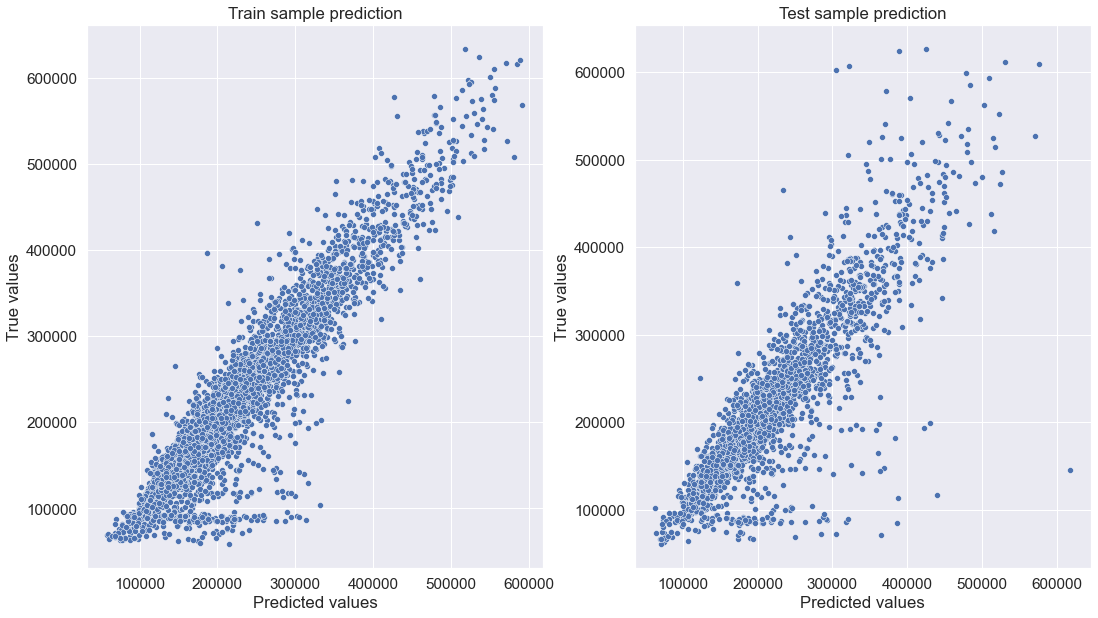

In [1022]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

## 4. Формирование файла с прогнозами

In [1023]:
test_df = features_gen.transform(test_df)

In [1024]:
y_test = gb_model.predict(test_df[feature_names + new_feature_names])
y_test

array([162944.74186069, 123060.21488811, 148986.41895092, ...,
       144267.63156786, 176129.23478763, 297616.27106197])

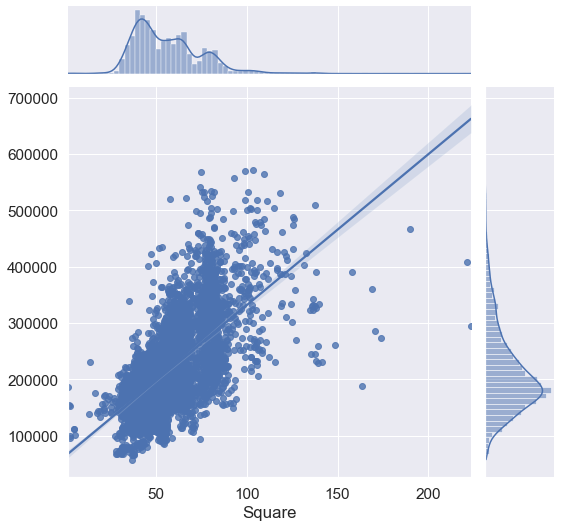

In [1025]:
# Анализ зависимости цены от площади для прогноза очень похож на таковой в трейнинговом наборе.
grid = sns.jointplot(test_df['Square'], y_test, kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

In [1026]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = y_test
pred_df.to_csv("./predictions_.csv", index=False)